# 1. Import Libraries
- These are core libraries used for data augmentation, building CNN, and optimizing the model. ImageDataGenerator is used for data augmentation, and MobileNetV2 will be used for transfer learning.

In [1]:
# Import necessary libraries
import os
import shutil
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import kagglehub

# 2. Download Dataset via KaggleHub

In [2]:
# Download the TrashNet dataset from Kaggle
path = kagglehub.dataset_download("feyzazkefe/trashnet")
print("Path to dataset files:", path)

100%|██████████| 40.8M/40.8M [00:19<00:00, 2.15MB/s]

Extracting files...


Path to dataset files: C:\Users\MK\.cache\kagglehub\datasets\feyzazkefe\trashnet\versions\1


# 3. Splitting the Dataset
This code will:
- Create the train/, val/, and test/ directories for each class.
- Randomly shuffle and split the images in each class into 70% training, 15% validation, and 15% test sets.
- Move the files to the appropriate directories.

In [3]:
import random

# Define the paths to the original dataset and where you want to move the splits
dataset_path = os.path.join(path, 'dataset-resized')
train_dir = r"E:\My Courses\University\5- Projects\AI-Driven Smart Waste Sorting\data\train"
val_dir = r"E:\My Courses\University\5- Projects\AI-Driven Smart Waste Sorting\data\val"
test_dir = r"E:\My Courses\University\5- Projects\AI-Driven Smart Waste Sorting\data\test"

In [4]:
# Create directories for train, val, and test if they don't exist
def create_dirs(base_dir, categories):
    for category in categories:
        os.makedirs(os.path.join(base_dir, category), exist_ok=True)

In [5]:
# Split the dataset into train, val, and test
def split_data(dataset_path, train_dir, val_dir, test_dir, split_ratio=(0.7, 0.15, 0.15)):
    categories = ['glass', 'paper', 'plastic', 'metal', 'cardboard', 'trash']
    
    # Create directories for train, val, and test
    create_dirs(train_dir, categories)
    create_dirs(val_dir, categories)
    create_dirs(test_dir, categories)

    for category in categories:
        category_path = os.path.join(dataset_path, category)
        images = os.listdir(category_path)
        random.shuffle(images)

        # Calculate the split indexes
        train_idx = int(split_ratio[0] * len(images))
        val_idx = int((split_ratio[0] + split_ratio[1]) * len(images))

        # Split the data
        train_images = images[:train_idx]
        val_images = images[train_idx:val_idx]
        test_images = images[val_idx:]

        # Move the files to the respective directories
        for img in train_images:
            shutil.copy(os.path.join(category_path, img), os.path.join(train_dir, category, img))
        
        for img in val_images:
            shutil.copy(os.path.join(category_path, img), os.path.join(val_dir, category, img))
        
        for img in test_images:
            shutil.copy(os.path.join(category_path, img), os.path.join(test_dir, category, img))

In [6]:
# Split the dataset
split_data(dataset_path, train_dir, val_dir, test_dir)

# 4. Data Augmentation and Loading
- Now that we have the dataset split into training, validation, and test sets, we will use ImageDataGenerator to load and augment the data.

In [7]:
# Data augmentation for the training set
train_datagen = ImageDataGenerator(
    rescale=1./255,           # Rescale pixel values from 0-255 to 0-1
    shear_range=0.2,          # Randomly shear images
    zoom_range=0.2,           # Randomly zoom into images
    horizontal_flip=True      # Randomly flip images horizontally
)

In [8]:
# No augmentation for validation and test sets, just rescale
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

In [9]:
# Load the datasets
train_generator = train_datagen.flow_from_directory(
    train_dir,                # Path to the training data
    target_size=(224, 224),   # Resize images to 224x224
    batch_size=32,            # Batch size
    class_mode='categorical'  # Multi-class classification
)

validation_generator = val_datagen.flow_from_directory(
    val_dir,                  # Path to the validation data
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,                 # Path to the test data
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

Found 1766 images belonging to 6 classes.
Found 378 images belonging to 6 classes.
Found 383 images belonging to 6 classes.


# 5. Loading the Pretrained Model and Adding Custom Layers
- This part is the same as before, where we use MobileNetV2 for transfer learning.

In [10]:
# Load MobileNetV2 pretrained on ImageNet and remove the top classification layer
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

In [11]:
# Freeze the base model layers so they don't get updated during training
for layer in base_model.layers:
    layer.trainable = False

In [12]:
# Add custom layers on top of MobileNetV2
x = base_model.output
x = GlobalAveragePooling2D()(x)          # Global Average Pooling
x = Dense(1024, activation='relu')(x)    # Dense layer with ReLU activation
predictions = Dense(train_generator.num_classes, activation='softmax')(x)  # Output layer for classification

In [13]:
# Build the final model
model = Model(inputs=base_model.input, outputs=predictions)

# 6. Compile the Model

In [15]:
# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# 7. Callbacks and Training

In [16]:
# Set up early stopping and model checkpoint to save the best model
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
checkpoint = ModelCheckpoint('models/best_model.keras', monitor='val_loss', save_best_only=True)

In [17]:
# Train the model
history = model.fit(
    train_generator,
    epochs=10,                        # Number of epochs
    validation_data=validation_generator,
    callbacks=[early_stopping, checkpoint]
)

C:\Users\MK\AppData\Roaming\Python\Python312\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 48s 788ms/step - accuracy: 0.4720 - loss: 1.3752 - val_accuracy: 0.7249 - val_loss: 0.7523
Epoch 2/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 34s 612ms/step - accuracy: 0.7907 - loss: 0.6170 - val_accuracy: 0.7751 - val_loss: 0.6529
Epoch 3/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 34s 611ms/step - accuracy: 0.8329 - loss: 0.5099 - val_accuracy: 0.7804 - val_loss: 0.6277
Epoch 4/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 33s 587ms/step - accuracy: 0.8787 - loss: 0.3843 - val_accuracy: 0.7857 - val_loss: 0.5848
Epoch 5/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 34s 605ms/step - accuracy: 0.9080 - loss: 0.3188 - val_accuracy: 0.7778 - val_loss: 0.5863
Epoch 6/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 34s 613ms/step - accuracy: 0.9146 - loss: 0.2939 - val_accuracy: 0.7910 - val_loss: 0.5860
Epoch 7/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 33s 588ms/step - accuracy: 0.9169 - loss: 0.2709 - val_accuracy: 0.8042 - val_loss: 0.5355
Epoch 8/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 32s 571ms/step - accuracy: 0.9302 - loss: 0.2530 - val_accu

# 8. Evaluate on Test Data
Once the model is trained, we can evaluate it on the test dataset.

In [18]:
# Evaluate the model on the test data
test_loss, test_acc = model.evaluate(test_generator)
print(f'Test Accuracy: {test_acc * 100:.2f}%')

12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 490ms/step - accuracy: 0.8347 - loss: 0.4077
Test Accuracy: 84.07%


# 9. Plotting Accuracy and Loss Curves

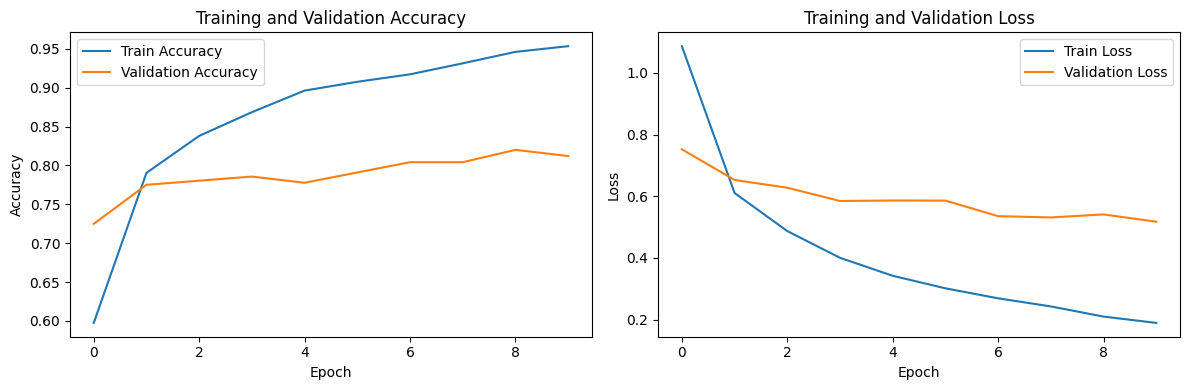

In [19]:
# Plot training & validation accuracy and loss

import matplotlib.pyplot as plt

def plot_training(history):
    # Plot the accuracy
    plt.figure(figsize=(12, 4))

    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Call the function to plot the graphs
plot_training(history)

# 10. Saving the Model

In [21]:
# Save the trained model to be used in Streamlit
model.save('models/waste_sorting_model_final.keras')